# ニューラルネットワークの学習
勾配法を使ったパラメータの決定
## データから学習する
### データ駆動
画像から**特徴量**を抽出して、それらの値をベクトルに変換してそのパターンを学習する


特徴量・・・・  
あるものを特徴づける最適な変数のこと. コップであれば、大きさ、重さ、直径、形状など  
* 機械学習・・・特徴量を人間が考えて設計する
* 深層学習・・・特徴量も機械が学習して設定する  

つまり、ニューラルネットワークは、対象とする問題に関係なく、データをそのままの生データとして、“end-to-end”で学習することができる！！

### 訓練データとテストデータ

* 訓練データ(教師データ)
* テストデータ

なぜ分けるのか...？  
* 任意のデータセットに対しても正確に学習できるようにするため  
 (訓練データに対する癖のある学習をしている恐れ)
* あるデータセットだけに過度に対応した状態を**過学習**と言う  

## 損失関数

*損失関数とは、ニューラルネットワークの性能の悪さを表す指標*

### 2乗和誤差
* 最も有名

$E= \frac{1}{2} \sum_{k}^{} (y_k-t_k)^2$  

yk はニューラルネットワークの出力、tk は教師データ、k はデー タの次元数


In [9]:
# 実装例
import numpy as np
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [5]:
t = [0, 0, 1, 0 , 0, 0, 0, 0, 0, 0] # 2が正解
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] #２の確率が一番高い
mean_squared_error(np.array(y), np.array(t)) # 出力は小さい

0.097500000000000031

In [6]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]  # ７の確率が一番高い
mean_squared_error(np.array(y), np.array(t))　# 出力は大きい

0.59750000000000003

### 交差エントロピー誤差
* 正解ラベルが 1 に対応する出力の自然対数を計算するだけ
* 正解ラベルに対応する出力が大きいほど、０に近く(自然対数のグラフを参考)

$E=  \sum_{k}^{} t_k \log y_k $  



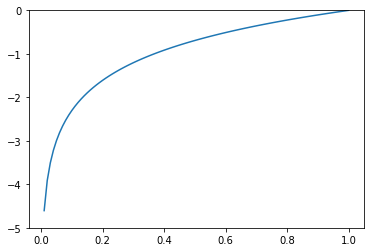

In [28]:
# x=0~1の時のlogxのグラフ
import matplotlib.pylab as plt

x = np.arange(0.01, 1.01, 0.01)
y = np.log(x)
plt.plot(x, y)
plt.ylim(-5.0, 0.0) 
plt.show()

In [26]:
# 実装
def base_cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [27]:
t = [0, 0, 1, 0 , 0, 0, 0, 0, 0, 0] # 2が正解
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] #２の確率が一番高い
base_cross_entropy_error(np.array(y), np.array(t)) # 出力は小さい

0.51082545709933802

In [28]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]  # ７の確率が一番高い
base_cross_entropy_error(np.array(y), np.array(t)) # 出力は大きい

2.3025840929945458

### ミニバッチ学習
膨大な訓練データから、いくつかのデータを取り出して学習させること


In [24]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = \
      load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape) # (60000, 784)
print(t_train.shape) # (60000, 10)

(60000, 784)
(60000, 10)


In [25]:
train_size = x_train.shape[0]
batch_size = 10
np.random.choice(train_size, batch_size) # ランダムに10個取り出し

array([59721, 38890, 41329, 45627, 12425, 38786, 25971, 20058, 38012, 42388])

### バッチ対応版　交差エントロピーの実装

In [23]:
# 何をやっているのかちゃんと理解するべき
def cross_entropy_error(y, t):
    if y.ndim == 1:                       # 全て２次元データにする
        t = t.reshape(1, t.size)   
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return - np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [87]:
#   np.arange(batch_size) は、0 から batch_size-1 までの配列を生成

#  y[np.arange(batch_size), t] は、
#  各データの正解ラベルに対応するニューラルネットワークの出力を抽出します
#  [y[0,2], y[1,7], y[2,0], y[3,9], y[4,4]] の NumPy 配列を生成します

### 損失関数を用いる理由
> 認識精度を指標にすると、パラメータの微分がほとんどの場所で 0 になってしまうからである。

これはなぜか....?
* 認識精度は、微小変化に応答しない
* 不連続な変化を示す (関数的な応答を示さない)

**=> 傾きが 0 にはならない時に、ニューラルネットワークは正しい学習が行えるようになる**

## 数値微分
### 微分
**定義**
$$\frac{ \mathrm{d}f(x) }{ \mathrm{d}x } = \lim_{h \to \infty} \frac {f(x+h)- f(x)}{h} $$

In [30]:
# 悪い実装例
def numerical_diff(f, x):
    h = 10e-50 # 丸め誤差が生じる
    return (f(x+h)-f(x)) / h

In [31]:
# 丸め誤差
np.float32(10e-50)

0.0

In [32]:
# より精度の良い近似関数
def numerical_diff(f, x):
    h = 1e-4 # 0.001
    return ( f(x+h) - f(x-h) ) / (2 * h)

### 数値微分の例

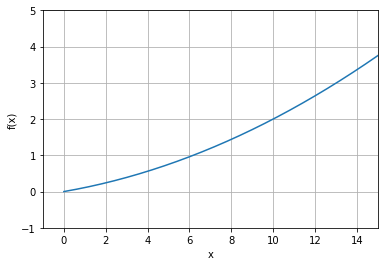

In [45]:
# y=0.01x^2 + 0.1xについて考察
def function1(x):
    return 0.01*x **2 + 0.1*x

# 壁画
x = np.arange(0.0, 20.0, 0.1)
y = function1(x)

plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.axis([-1, 15, -1, 5])
plt.grid(True)
plt.show()

In [36]:
numerical_diff(function1, 5)

0.1999999999990898

In [37]:
numerical_diff(function1,10)

0.2999999999986347

### 偏微分

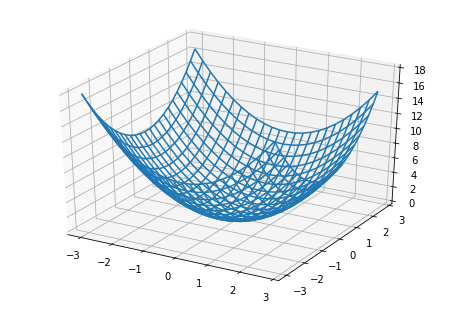

In [29]:
# f(x) = x0^2 + x1^2について考える

def function2(x):
    return np.sum(x**2)


# ３次元プロット
from mpl_toolkits.mplot3d import Axes3D

x0 = np.arange(-3, 3, 0.25)
x1 = np.arange(-3, 3, 0.25)
X0, X1 = np.meshgrid(x0, x1) 
Y = X0**2.0 + X1**2.0

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X0, X1, Y)

plt.show()

In [49]:
# x0=3, x1=4の時のx0についての偏微分

def function_tmp1(x0):
    return x0 * x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [50]:
# x0=3, x1=4の時のx1についての偏微分

def function_tmp2(x1):
    return 3.0**2.0 + x1 * x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 勾配
* すべての変数の偏微分をベクトルとしてまとめたもの
* 勾配が示す方向は、各場所において関数の値を最も減らす方向

In [25]:
# 勾配を求める関数
def numerical_gradient(f, x):
    h = 1e-4    # 0.001
    grad = np.zeros_like(x)   # xと同じ形状の０埋めした配列
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値を元にもどす
        
    return grad

In [30]:
numerical_gradient(function2, np.array([3.0, 4.0]))

array([ 6.,  8.])

In [61]:
numerical_gradient(function2, np.array([0.0, 2.0]))

array([ 0.,  4.])

In [63]:
numerical_gradient(function2, np.array([3.0, 0.0]))

array([ 6.,  0.])

### 勾配法
* 損失関数の最小値を探すため、勾配方向に進むことを繰り返して、関数の値を減らす方法
* 最小値を探す場合・・・勾配降下法
* 最大値を探す場合・・・勾配上昇法 (勾配の符号を逆転させ使用)

数式は以下のように表せる  

$x_0 = x_0 - \eta \frac { \partial f}{ \partial x_0}$  
$x_1 = x_1 - \eta \frac { \partial f}{ \partial x_1}$  

$\eta$ は、更新の量を示し、**学習率**と呼ばれる。どれだけパラメータを変化させるかの指標。この学習率を変化させて、正しく学習できているかどうか確認するのが一般的な方法

In [92]:
# 勾配降下法の実装
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        
    return x   

In [96]:
# test
init_x = np.array([-3.0, 4.0])
gradient_descent(function2, init_x=init_x, lr=0.1, step_num=100) ## ほぼ０に近い値

array([ -6.11110793e-10,   8.14814391e-10])

In [97]:
# 学習率を大きくする
init_x = np.array([-3.0, 4.0])
gradient_descent(function2, init_x=init_x, lr=10.0, step_num=100)

array([ -2.58983747e+13,  -1.29524862e+12])

In [98]:
# 学習率を小さくする
init_x = np.array([-3.0, 4.0])
gradient_descent(function2, init_x=init_x, lr=1e-10, step_num=100)

array([-2.99999994,  3.99999992])

### ニューラルネットワークに対する勾配
ここでいう勾配は、３つの重みパラメータに関する損失関数の勾配  
$W^{(1)} = \begin{pmatrix}
 w_{11}^{(1)} &  w_{21}^{(1)} &  w_{31}^{(1)} \\
 w_{12}^{(1)} &  w_{22}^{(1)} &  w_{32}^{(1)} \\
\end{pmatrix}
$  
$ \frac { \partial L}{ \partial W} = \begin{pmatrix}
 \frac { \partial L}{ \partial w_{11}} &  \frac { \partial L}{ \partial w_{12}} &  \frac { \partial L}{ \partial w_{13}} \\
 \frac { \partial L}{ \partial w_{21}} &  \frac { \partial L}{ \partial w_{22}} &  \frac { \partial L}{ \partial w_{23}} \\
\end{pmatrix}
$

In [7]:
def softmax(x):
    c = np.max(x)
    exp_a = np.exp(x - c) # オーバーフロー対策
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布で初期化、一様ではなく
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [8]:
net = simpleNet()
print(net.W)

[[-0.65905927 -0.4532871   0.28149188]
 [-0.46602843 -2.13939165 -1.07125524]]


In [8]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-2.26496365 -1.53111567 -0.55010873]


In [9]:
np.argmax(p)

2

In [12]:
t = np.array([0, 0, 1])
net.loss(x, t)

5.7349931058314141

In [16]:
net = simpleNet()
f = lambda w: net.loss(x, t)
print(net.W)

dW = numerical_gradient(f, net.W)

[[ 0.70810468  1.16215951 -0.5140364 ]
 [ 0.26471999  0.34811524 -0.13313716]]


IndexError: index 2 is out of bounds for axis 0 with size 2

## 学習アルゴリズムの実装

**学習の手順**
* ミニバッチ・・・訓練データからランダムにデータを取得する。このデータの損失関数を減らすことが目標
* 勾配の算出・・・損失関数を減らすために、各パラメータの勾配を算出
* パラメーターの更新・・・各パラメータを勾配方向に微小量変化させる
* 繰り返し・・・以上の操作を繰り返す

以上の方法を、**確率的勾配降下法(SGD)**という名前で呼ぶ


### ２層のニューラルネットワークの実装

In [2]:
import numpy as np
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] =  weight_init_std * \
                                       np.random.rand(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] =  weight_init_std * \
                                       np.random.rand(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    #  x: 入力データ, t: 教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum( y == t ) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

In [3]:
# 一個ずつ実行してみる
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [4]:
net.params['W1'].shape

(784, 100)

In [5]:
net.params['W2'].shape

(100, 10)

In [6]:
x = np.random.rand(100,784)
print(x) # 実際は評価したいデータを突っ込む

[[ 0.23711012  0.30384765  0.153632   ...,  0.24317636  0.56924572
   0.18610231]
 [ 0.22324479  0.47893054  0.14668994 ...,  0.10012473  0.84372693
   0.0357482 ]
 [ 0.13048061  0.33225846  0.99752296 ...,  0.28750083  0.36108102
   0.0474778 ]
 ..., 
 [ 0.91153545  0.48151276  0.52615396 ...,  0.61589733  0.68170429
   0.87773686]
 [ 0.58247056  0.05528859  0.73324087 ...,  0.89790173  0.72307447
   0.95039719]
 [ 0.05404253  0.40445294  0.04867293 ...,  0.42805757  0.44511151
   0.84017381]]


In [7]:
y = net.predict(x) # 推論結果

In [8]:
t = np.random.rand(100, 10) # 正解ラベル
grads = net.numerical_gradient(x, t) # すごく重い → 誤差逆伝播法を使って高速処理させる

In [9]:
net.accuracy(x, t)

0.12

In [3]:
# バッチ
# エポック・・・学習の単位
 
import numpy as np
from dataset.mnist import load_mnist
from sample.two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
         load_mnist(normalize=True, one_hot_label=True)
    
train_loss_list = []
train_acc_list = []
test_acc_list = []

#  ハイパーパラメータ
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

# １エポックあたりの繰り返し数
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # ミニバッチの取得
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 学習経過の記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + " , " + str(test_acc))

train acc, test acc | 0.0987166666667 , 0.098
train acc, test acc | 0.787033333333 , 0.7893
train acc, test acc | 0.878083333333 , 0.8841
train acc, test acc | 0.900033333333 , 0.9034
train acc, test acc | 0.909316666667 , 0.9142
train acc, test acc | 0.915766666667 , 0.9188
train acc, test acc | 0.921466666667 , 0.9227
train acc, test acc | 0.924983333333 , 0.9265
train acc, test acc | 0.928783333333 , 0.9313
train acc, test acc | 0.9324 , 0.9328
train acc, test acc | 0.93515 , 0.9361
train acc, test acc | 0.937483333333 , 0.9387
train acc, test acc | 0.939766666667 , 0.9405
train acc, test acc | 0.942516666667 , 0.9425
train acc, test acc | 0.944966666667 , 0.9435
train acc, test acc | 0.946833333333 , 0.9451
train acc, test acc | 0.948216666667 , 0.947


# まとめ

* ニューラルネットワークの学習は、損失関数を指標として、損失関数の値 が小さくなるように、重みパラメータを更新する
* 重みパラメータを更新する際には、重みパラメータの勾配を利用して、勾配方向に重みの値を更新する作業を繰り返す。
* 数値微分による計算には時間がかかる